In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [11]:
def splitDataIntoChunks3D(data, chunk_size): #chunk_size is 5
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:5])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [12]:
#set random seed 
tf.random.set_seed(42)

In [13]:
#find minimum episode duration in training set
train_episode_duration_list = []
for train_episode in train_data_cleaned:
    train_episode_duration_list.append(len(train_episode))
train_episode_duration_list

[10,
 12,
 6,
 19,
 9,
 8,
 6,
 16,
 11,
 9,
 15,
 13,
 8,
 14,
 12,
 11,
 12,
 8,
 12,
 6,
 10,
 28,
 14,
 19,
 8,
 5,
 13,
 14,
 10,
 12,
 15,
 9,
 14,
 7,
 13,
 19,
 8,
 11,
 23,
 20,
 15,
 11,
 20,
 9,
 14,
 16,
 10,
 8,
 8,
 14,
 13,
 19,
 20,
 11,
 10,
 21,
 9,
 11,
 16,
 9,
 14,
 9,
 11,
 14,
 13,
 9,
 8,
 16,
 9,
 16,
 19,
 15,
 10,
 12,
 7,
 12,
 13,
 19,
 11,
 12,
 16,
 23,
 8,
 9,
 11,
 16,
 12,
 17,
 7,
 13,
 8,
 12,
 16,
 9,
 13,
 11,
 8,
 14,
 11,
 11,
 13,
 29,
 9,
 11,
 10,
 13,
 17,
 12,
 9,
 9,
 11,
 14,
 14,
 9,
 13,
 18,
 17,
 15,
 12,
 6,
 13,
 13,
 14,
 11,
 7,
 20,
 6,
 15,
 12,
 6,
 13,
 14,
 7,
 13,
 15,
 7,
 15,
 10,
 12,
 16,
 25,
 17,
 19,
 14,
 26,
 8,
 8,
 6,
 13,
 19,
 9,
 16,
 18,
 15,
 17,
 18,
 13,
 16,
 10,
 9,
 13,
 10,
 10,
 10,
 16,
 8,
 17,
 28,
 13,
 8,
 5,
 15,
 6,
 12,
 8,
 10,
 7,
 11,
 11,
 16,
 11,
 18,
 8,
 8,
 13,
 11,
 7,
 13,
 15,
 7,
 20,
 20,
 15,
 25,
 9,
 9,
 6,
 17,
 27,
 9,
 12,
 18,
 10,
 20,
 9,
 12,
 9,
 16,
 19,
 15,
 22,
 7,
 

In [14]:
min_train_episode_duration = min(train_episode_duration_list)
min_train_episode_duration

5

In [15]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

### Attempt 1: Timestep = 1, Train with Degradation Data Only

In [16]:
(trainX_1step, trainY_1step, trainTime_1step) = splitDataIntoChunks3D(train_data_cleaned, 1)
(valX_1step, valY_1step, valTime_1step) = splitDataIntoChunks3D(val_data, 1)
(testX_1step, testY_1step, testTime_1step) = splitDataIntoChunks3D(test_data, 1)

In [17]:
#check shape of X (training)
trainX_1step_arr = np.array(trainX_1step)
trainX_1step_arr.shape

(4935, 1, 4)

In [18]:
#check shape of y (training)
trainY_1step_arr = np.array(trainY_1step)
trainY_1step_arr = trainY_1step_arr.reshape(-1, 1)
trainY_1step_arr.shape

(4935, 1)

In [19]:
#check shape of X (validation)
valX_1step_arr = np.array(valX_1step)
valX_1step_arr.shape

(884, 1, 4)

In [20]:
#check shape of y (validation)
valY_1step_arr = np.array(valY_1step)
valY_1step_arr = valY_1step_arr.reshape(-1, 1)
valY_1step_arr.shape

(884, 1)

In [20]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(1, 4), padding="same"))
model1.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model1.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model1.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [22]:
fileName1 = "CNN_timestepTest_oneTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [23]:
learning_model1 = model1.fit(trainX_1step_arr, trainY_1step_arr, epochs=500, batch_size=32, validation_data=(valX_1step_arr, valY_1step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
155/155 [==============================] - 2s 7ms/step - loss: 32.7990 - mean_squared_error: 32.7990 - val_loss: 16.3035 - val_mean_squared_error: 16.3035
Epoch 2/500
155/155 [==============================] - 1s 3ms/step - loss: 24.8210 - mean_squared_error: 24.8210 - val_loss: 16.3461 - val_mean_squared_error: 16.3461
Epoch 3/500
155/155 [==============================] - 1s 3ms/step - loss: 24.2098 - mean_squared_error: 24.2098 - val_loss: 16.6280 - val_mean_squared_error: 16.6280
Epoch 4/500
155/155 [==============================] - 1s 4ms/step - loss: 23.7943 - mean_squared_error: 23.7943 - val_loss: 17.2054 - val_mean_squared_error: 17.2054
Epoch 5/500
155/155 [==============================] - 1s 4ms/step - loss: 23.4147 - mean_squared_error: 23.4147 - val_loss: 17.6169 - val_mean_squared_error: 17.6169
Epoch 6/500
155/155 [==============================] - 1s 4ms/step - loss: 22.9585 - mean_squared_error: 22.9585 - val_loss: 17.4712 - val_mean_squared_error: 17.471

Epoch 50/500
155/155 [==============================] - 1s 4ms/step - loss: 21.3189 - mean_squared_error: 21.3189 - val_loss: 16.0580 - val_mean_squared_error: 16.0580
Epoch 51/500
155/155 [==============================] - 1s 5ms/step - loss: 21.3747 - mean_squared_error: 21.3747 - val_loss: 16.1124 - val_mean_squared_error: 16.1124
Epoch 52/500
155/155 [==============================] - 1s 4ms/step - loss: 21.3699 - mean_squared_error: 21.3699 - val_loss: 16.3008 - val_mean_squared_error: 16.3008
Epoch 53/500
155/155 [==============================] - 1s 4ms/step - loss: 21.3343 - mean_squared_error: 21.3343 - val_loss: 16.4015 - val_mean_squared_error: 16.4015
Epoch 54/500
155/155 [==============================] - 1s 4ms/step - loss: 21.2140 - mean_squared_error: 21.2140 - val_loss: 16.0018 - val_mean_squared_error: 16.0018
Epoch 55/500
155/155 [==============================] - 1s 4ms/step - loss: 21.3652 - mean_squared_error: 21.3652 - val_loss: 15.9665 - val_mean_squared_error: 

155/155 [==============================] - 1s 5ms/step - loss: 21.1354 - mean_squared_error: 21.1354 - val_loss: 15.7523 - val_mean_squared_error: 15.7523
Epoch 147/500
155/155 [==============================] - 1s 8ms/step - loss: 21.1032 - mean_squared_error: 21.1032 - val_loss: 15.8174 - val_mean_squared_error: 15.8174
Epoch 148/500
155/155 [==============================] - 1s 8ms/step - loss: 21.1427 - mean_squared_error: 21.1427 - val_loss: 15.7247 - val_mean_squared_error: 15.7247
Epoch 149/500
155/155 [==============================] - 1s 8ms/step - loss: 21.1688 - mean_squared_error: 21.1688 - val_loss: 15.6768 - val_mean_squared_error: 15.6768
Epoch 150/500
155/155 [==============================] - 1s 8ms/step - loss: 21.2449 - mean_squared_error: 21.2449 - val_loss: 15.9242 - val_mean_squared_error: 15.9242
Epoch 151/500
155/155 [==============================] - 1s 8ms/step - loss: 21.1898 - mean_squared_error: 21.1898 - val_loss: 15.5995 - val_mean_squared_error: 15.5995


155/155 [==============================] - 1s 5ms/step - loss: 21.1094 - mean_squared_error: 21.1094 - val_loss: 15.1882 - val_mean_squared_error: 15.1882
Epoch 243/500
155/155 [==============================] - 1s 5ms/step - loss: 21.1551 - mean_squared_error: 21.1551 - val_loss: 15.3847 - val_mean_squared_error: 15.3847
Epoch 244/500
155/155 [==============================] - 1s 5ms/step - loss: 21.0674 - mean_squared_error: 21.0674 - val_loss: 15.3668 - val_mean_squared_error: 15.3668
Epoch 245/500
155/155 [==============================] - 1s 5ms/step - loss: 21.1226 - mean_squared_error: 21.1226 - val_loss: 15.2394 - val_mean_squared_error: 15.2394
Epoch 246/500
155/155 [==============================] - 1s 4ms/step - loss: 21.1266 - mean_squared_error: 21.1266 - val_loss: 15.4193 - val_mean_squared_error: 15.4193
Epoch 247/500
155/155 [==============================] - 1s 4ms/step - loss: 21.0465 - mean_squared_error: 21.0465 - val_loss: 15.1367 - val_mean_squared_error: 15.1367


Epoch 290/500
155/155 [==============================] - 1s 3ms/step - loss: 21.1035 - mean_squared_error: 21.1035 - val_loss: 15.3271 - val_mean_squared_error: 15.3271
Epoch 291/500
155/155 [==============================] - 0s 3ms/step - loss: 21.1311 - mean_squared_error: 21.1311 - val_loss: 15.4229 - val_mean_squared_error: 15.4229
Epoch 292/500
155/155 [==============================] - 1s 3ms/step - loss: 21.1535 - mean_squared_error: 21.1535 - val_loss: 15.2745 - val_mean_squared_error: 15.2745
Epoch 293/500
155/155 [==============================] - 0s 3ms/step - loss: 21.0823 - mean_squared_error: 21.0823 - val_loss: 15.4478 - val_mean_squared_error: 15.4478
Epoch 294/500
155/155 [==============================] - 0s 3ms/step - loss: 21.1221 - mean_squared_error: 21.1221 - val_loss: 15.3866 - val_mean_squared_error: 15.3866
Epoch 295/500
155/155 [==============================] - 0s 3ms/step - loss: 21.0723 - mean_squared_error: 21.0723 - val_loss: 15.5936 - val_mean_squared_e

155/155 [==============================] - 0s 2ms/step - loss: 21.0327 - mean_squared_error: 21.0327 - val_loss: 15.2790 - val_mean_squared_error: 15.2790
Epoch 387/500
155/155 [==============================] - 0s 2ms/step - loss: 20.9991 - mean_squared_error: 20.9991 - val_loss: 15.2620 - val_mean_squared_error: 15.2620
Epoch 388/500
155/155 [==============================] - 0s 3ms/step - loss: 21.0501 - mean_squared_error: 21.0501 - val_loss: 15.3125 - val_mean_squared_error: 15.3125
Epoch 389/500
155/155 [==============================] - 0s 3ms/step - loss: 21.0703 - mean_squared_error: 21.0703 - val_loss: 15.2414 - val_mean_squared_error: 15.2414
Epoch 390/500
155/155 [==============================] - 0s 3ms/step - loss: 21.0309 - mean_squared_error: 21.0309 - val_loss: 15.1979 - val_mean_squared_error: 15.1979
Epoch 391/500
155/155 [==============================] - 0s 3ms/step - loss: 20.9933 - mean_squared_error: 20.9933 - val_loss: 15.1999 - val_mean_squared_error: 15.1999


155/155 [==============================] - 0s 2ms/step - loss: 20.9633 - mean_squared_error: 20.9633 - val_loss: 15.0921 - val_mean_squared_error: 15.0921
Epoch 483/500
155/155 [==============================] - 0s 3ms/step - loss: 20.9172 - mean_squared_error: 20.9172 - val_loss: 14.9698 - val_mean_squared_error: 14.9698
Epoch 484/500
155/155 [==============================] - 0s 2ms/step - loss: 20.9124 - mean_squared_error: 20.9124 - val_loss: 15.0284 - val_mean_squared_error: 15.0284
Epoch 485/500
155/155 [==============================] - 0s 3ms/step - loss: 20.9823 - mean_squared_error: 20.9823 - val_loss: 14.9764 - val_mean_squared_error: 14.9764
Epoch 486/500
155/155 [==============================] - 0s 2ms/step - loss: 20.9393 - mean_squared_error: 20.9393 - val_loss: 15.0036 - val_mean_squared_error: 15.0036
Epoch 487/500
155/155 [==============================] - 0s 2ms/step - loss: 20.9596 - mean_squared_error: 20.9596 - val_loss: 15.0181 - val_mean_squared_error: 15.0181


In [21]:
model1 = tf.keras.models.load_model('CNN_timestepTest_oneTimestep.h5')

In [25]:
#performance on training set
trainPredict1 = model1.predict(trainX_1step_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_1step_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_1step_arr, trainPredict1)
trainSscore1 = findSscore(trainY_1step_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.7059 RMSE 0.0380 R2 Score 6906.4350 S score


In [26]:
#performance on validation set
valPredict1 = model1.predict(valX_1step_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_1step_arr, valPredict1))
valR2Score1 = r2_score(valY_1step_arr, valPredict1)
valSscore1 = findSscore(valY_1step_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 3.8590 RMSE 0.0880 R2 Score 1184.3784 S score


In [27]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [28]:
valTime_1step

[6011,
 6012,
 6013,
 6014,
 6015,
 6016,
 6017,
 6018,
 6019,
 6020,
 6021,
 6022,
 6023,
 6025,
 6026,
 6027,
 6029,
 6030,
 6031,
 6032,
 6033,
 6034,
 6035,
 6036,
 6037,
 6038,
 6039,
 6040,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6052,
 6053,
 6054,
 6055,
 6056,
 6057,
 6058,
 6059,
 6060,
 6061,
 6062,
 6063,
 6064,
 6065,
 6066,
 6068,
 6069,
 6070,
 6071,
 6072,
 6073,
 6074,
 6076,
 6077,
 6078,
 6079,
 6080,
 6081,
 6082,
 6083,
 6084,
 6085,
 6086,
 6087,
 6088,
 6090,
 6091,
 6092,
 6093,
 6094,
 6095,
 6096,
 6097,
 6098,
 6099,
 6100,
 6101,
 6102,
 6104,
 6105,
 6106,
 6107,
 6108,
 6109,
 6110,
 6111,
 6112,
 6113,
 6114,
 6115,
 6116,
 6118,
 6119,
 6120,
 6121,
 6123,
 6124,
 6125,
 6126,
 6127,
 6129,
 6130,
 6131,
 6132,
 6133,
 6134,
 6135,
 6137,
 6138,
 6139,
 6140,
 6141,
 6142,
 6143,
 6145,
 6146,
 6147,
 6148,
 6149,
 6150,
 6151,
 6152,
 6153,
 6154,
 6156,
 6157,
 6158,
 6159,
 6160,
 6161,
 6162,
 6163,
 6164,
 6166,
 6167,
 6168,

In [29]:
allRUL = all_df['RUL']
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_1step, 6010, 6976)

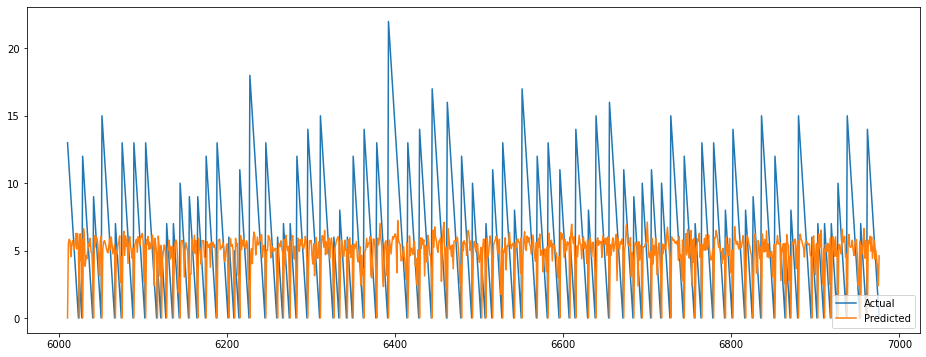

In [30]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal1)
plt.plot(timeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

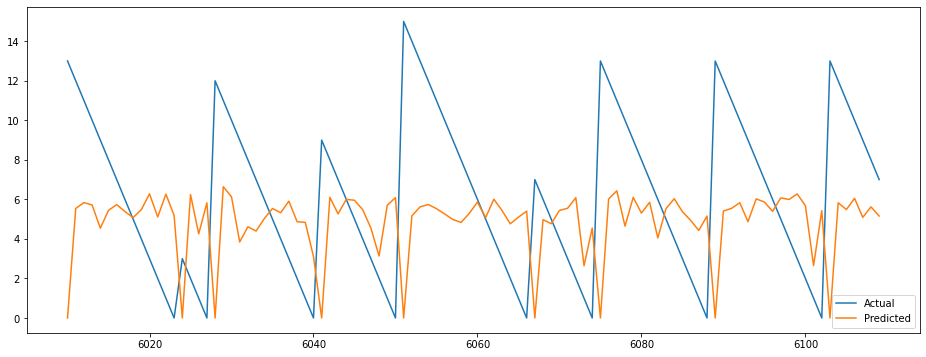

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal1[0:100])
plt.plot(timeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 2: Timestep = 2, train with degradation data

In [27]:
(trainX_2step, trainY_2step, trainTime_2step) = splitDataIntoChunks3D(train_data_cleaned, 2)
(valX_2step, valY_2step, valTime_2step) = splitDataIntoChunks3D(val_data, 2)
(testX_2step, testY_2step, testTime_2step) = splitDataIntoChunks3D(test_data, 2)

In [28]:
#check shape of X (training)
trainX_2step_arr = np.array(trainX_2step)
trainX_2step_arr.shape

(4508, 2, 4)

In [29]:
#check shape of y (training)
trainY_2step_arr = np.array(trainY_2step)
trainY_2step_arr = trainY_2step_arr.reshape(-1, 1)
trainY_2step_arr.shape

(4508, 1)

In [30]:
#check shape of X (validation)
valX_2step_arr = np.array(valX_2step)
valX_2step_arr.shape

(801, 2, 4)

In [31]:
#check shape of y (validation)
valY_2step_arr = np.array(valY_2step)
valY_2step_arr = valY_2step_arr.reshape(-1, 1)
valY_2step_arr.shape

(801, 1)

In [32]:
#configure architecture 
model2 = models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(2, 4), padding="same"))
model2.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model2.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model2.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [38]:
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [39]:
fileName2 = "CNN_timestepTest_twoTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [40]:
learning_model2 = model2.fit(trainX_2step_arr, trainY_2step_arr, epochs=500, batch_size=32, validation_data=(valX_2step_arr, valY_2step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
141/141 [==============================] - 1s 3ms/step - loss: 23.8645 - mean_squared_error: 23.8645 - val_loss: 14.4504 - val_mean_squared_error: 14.4504
Epoch 2/500
141/141 [==============================] - 0s 2ms/step - loss: 21.9750 - mean_squared_error: 21.9750 - val_loss: 15.3783 - val_mean_squared_error: 15.3783
Epoch 3/500
141/141 [==============================] - 0s 3ms/step - loss: 21.3693 - mean_squared_error: 21.3693 - val_loss: 16.1340 - val_mean_squared_error: 16.1340
Epoch 4/500
141/141 [==============================] - 0s 3ms/step - loss: 21.0514 - mean_squared_error: 21.0514 - val_loss: 15.6655 - val_mean_squared_error: 15.6655
Epoch 5/500
141/141 [==============================] - 0s 3ms/step - loss: 20.6520 - mean_squared_error: 20.6520 - val_loss: 15.4323 - val_mean_squared_error: 15.4323
Epoch 6/500
141/141 [==============================] - 0s 3ms/step - loss: 20.5187 - mean_squared_error: 20.5187 - val_loss: 14.9369 - val_mean_squared_error: 14.936

Epoch 50/500
141/141 [==============================] - 0s 3ms/step - loss: 19.0811 - mean_squared_error: 19.0811 - val_loss: 14.1921 - val_mean_squared_error: 14.1921
Epoch 51/500
141/141 [==============================] - 0s 2ms/step - loss: 19.0001 - mean_squared_error: 19.0001 - val_loss: 14.3973 - val_mean_squared_error: 14.3973
Epoch 52/500
141/141 [==============================] - 0s 3ms/step - loss: 18.9669 - mean_squared_error: 18.9669 - val_loss: 14.4283 - val_mean_squared_error: 14.4283
Epoch 53/500
141/141 [==============================] - 0s 3ms/step - loss: 18.9859 - mean_squared_error: 18.9859 - val_loss: 14.0962 - val_mean_squared_error: 14.0962
Epoch 54/500
141/141 [==============================] - 0s 3ms/step - loss: 19.0446 - mean_squared_error: 19.0446 - val_loss: 14.2883 - val_mean_squared_error: 14.2883
Epoch 55/500
141/141 [==============================] - 0s 3ms/step - loss: 18.9727 - mean_squared_error: 18.9727 - val_loss: 14.0699 - val_mean_squared_error: 

Epoch 99/500
141/141 [==============================] - 0s 3ms/step - loss: 18.8519 - mean_squared_error: 18.8519 - val_loss: 13.6213 - val_mean_squared_error: 13.6213
Epoch 100/500
141/141 [==============================] - 0s 3ms/step - loss: 18.7947 - mean_squared_error: 18.7947 - val_loss: 13.3544 - val_mean_squared_error: 13.3544
Epoch 101/500
141/141 [==============================] - 0s 3ms/step - loss: 18.8171 - mean_squared_error: 18.8171 - val_loss: 13.2731 - val_mean_squared_error: 13.2731
Epoch 102/500
141/141 [==============================] - 0s 3ms/step - loss: 18.7675 - mean_squared_error: 18.7675 - val_loss: 13.4126 - val_mean_squared_error: 13.4126
Epoch 103/500
141/141 [==============================] - 0s 3ms/step - loss: 18.8339 - mean_squared_error: 18.8339 - val_loss: 13.3320 - val_mean_squared_error: 13.3320
Epoch 104/500
141/141 [==============================] - 0s 3ms/step - loss: 18.8053 - mean_squared_error: 18.8053 - val_loss: 13.2674 - val_mean_squared_er

141/141 [==============================] - 0s 2ms/step - loss: 18.5573 - mean_squared_error: 18.5573 - val_loss: 12.9564 - val_mean_squared_error: 12.9564
Epoch 196/500
141/141 [==============================] - 0s 2ms/step - loss: 18.5191 - mean_squared_error: 18.5191 - val_loss: 12.8716 - val_mean_squared_error: 12.8716
Epoch 197/500
141/141 [==============================] - 0s 2ms/step - loss: 18.5779 - mean_squared_error: 18.5779 - val_loss: 12.9217 - val_mean_squared_error: 12.9217
Epoch 198/500
141/141 [==============================] - 0s 2ms/step - loss: 18.5499 - mean_squared_error: 18.5499 - val_loss: 13.0879 - val_mean_squared_error: 13.0879
Epoch 199/500
141/141 [==============================] - 0s 2ms/step - loss: 18.5354 - mean_squared_error: 18.5354 - val_loss: 12.9234 - val_mean_squared_error: 12.9234
Epoch 200/500
141/141 [==============================] - 0s 2ms/step - loss: 18.5850 - mean_squared_error: 18.5850 - val_loss: 12.9418 - val_mean_squared_error: 12.9418


141/141 [==============================] - 0s 3ms/step - loss: 18.3525 - mean_squared_error: 18.3525 - val_loss: 12.9235 - val_mean_squared_error: 12.9235
Epoch 292/500
141/141 [==============================] - 0s 3ms/step - loss: 18.3743 - mean_squared_error: 18.3743 - val_loss: 12.9578 - val_mean_squared_error: 12.9578
Epoch 293/500
141/141 [==============================] - 0s 3ms/step - loss: 18.4262 - mean_squared_error: 18.4262 - val_loss: 12.9755 - val_mean_squared_error: 12.9755
Epoch 294/500
141/141 [==============================] - 0s 2ms/step - loss: 18.4345 - mean_squared_error: 18.4345 - val_loss: 12.8689 - val_mean_squared_error: 12.8689
Epoch 295/500
141/141 [==============================] - 0s 3ms/step - loss: 18.3997 - mean_squared_error: 18.3997 - val_loss: 12.9251 - val_mean_squared_error: 12.9251
Epoch 296/500
141/141 [==============================] - 0s 3ms/step - loss: 18.3999 - mean_squared_error: 18.3999 - val_loss: 12.9593 - val_mean_squared_error: 12.9593


141/141 [==============================] - 0s 3ms/step - loss: 18.3433 - mean_squared_error: 18.3433 - val_loss: 12.7836 - val_mean_squared_error: 12.7836
Epoch 388/500
141/141 [==============================] - 0s 3ms/step - loss: 18.1366 - mean_squared_error: 18.1366 - val_loss: 12.7351 - val_mean_squared_error: 12.7351
Epoch 389/500
141/141 [==============================] - 0s 3ms/step - loss: 18.1447 - mean_squared_error: 18.1447 - val_loss: 12.9141 - val_mean_squared_error: 12.9141
Epoch 390/500
141/141 [==============================] - 0s 3ms/step - loss: 18.2562 - mean_squared_error: 18.2562 - val_loss: 12.9084 - val_mean_squared_error: 12.9084
Epoch 391/500
141/141 [==============================] - 0s 3ms/step - loss: 18.1528 - mean_squared_error: 18.1528 - val_loss: 12.9582 - val_mean_squared_error: 12.9582
Epoch 392/500
141/141 [==============================] - 0s 3ms/step - loss: 18.2575 - mean_squared_error: 18.2575 - val_loss: 13.0668 - val_mean_squared_error: 13.0668


141/141 [==============================] - 0s 3ms/step - loss: 18.0648 - mean_squared_error: 18.0648 - val_loss: 12.9431 - val_mean_squared_error: 12.9431
Epoch 484/500
141/141 [==============================] - 0s 3ms/step - loss: 18.0882 - mean_squared_error: 18.0882 - val_loss: 12.8965 - val_mean_squared_error: 12.8965
Epoch 485/500
141/141 [==============================] - 0s 3ms/step - loss: 18.0270 - mean_squared_error: 18.0270 - val_loss: 12.8827 - val_mean_squared_error: 12.8827
Epoch 486/500
141/141 [==============================] - 1s 4ms/step - loss: 18.0616 - mean_squared_error: 18.0616 - val_loss: 12.8000 - val_mean_squared_error: 12.8000
Epoch 487/500
141/141 [==============================] - 0s 3ms/step - loss: 18.0386 - mean_squared_error: 18.0386 - val_loss: 12.8219 - val_mean_squared_error: 12.8219
Epoch 488/500
141/141 [==============================] - 0s 3ms/step - loss: 17.9101 - mean_squared_error: 17.9101 - val_loss: 12.7634 - val_mean_squared_error: 12.7634


In [33]:
model2 = tf.keras.models.load_model('CNN_timestepTest_twoTimestep.h5')

In [35]:
#performance on training set
trainPredict2 = model2.predict(trainX_2step_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_2step_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_2step_arr, trainPredict2)
trainSscore2 = findSscore(trainY_2step_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.4298 RMSE 0.0761 R2 Score 6145.4056 S score


In [36]:
#performance on validation set
valPredict2 = model2.predict(valX_2step_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_2step_arr, valPredict2))
valR2Score2 = r2_score(valY_2step_arr, valPredict2)
valSscore2 = findSscore(valY_2step_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 3.5522 RMSE 0.1340 R2 Score 1045.8318 S score


In [44]:
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_2step, 6010, 6976)

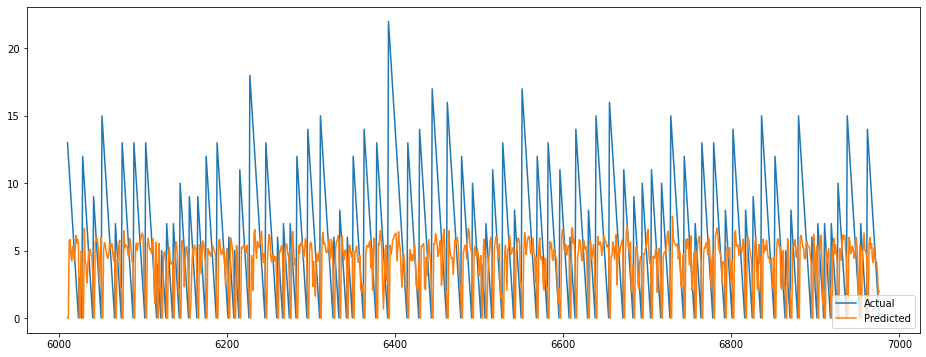

In [45]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal2)
plt.plot(timeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

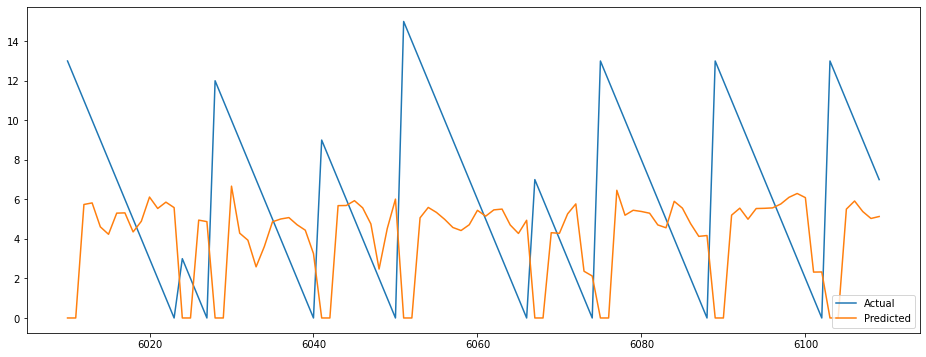

In [46]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal2[0:100])
plt.plot(timeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 3: Timestep = 3, train with degradation data

In [37]:
(trainX_3step, trainY_3step, trainTime_3step) = splitDataIntoChunks3D(train_data_cleaned, 3)
(valX_3step, valY_3step, valTime_3step) = splitDataIntoChunks3D(val_data, 3)
(testX_3step, testY_3step, testTime_3step) = splitDataIntoChunks3D(test_data, 3)

In [38]:
#check shape of X (training)
trainX_3step_arr = np.array(trainX_3step)
trainX_3step_arr.shape

(4081, 3, 4)

In [39]:
#check shape of y (training)
trainY_3step_arr = np.array(trainY_3step)
trainY_3step_arr = trainY_3step_arr.reshape(-1, 1)
trainY_3step_arr.shape

(4081, 1)

In [40]:
#check shape of X (validation)
valX_3step_arr = np.array(valX_3step)
valX_3step_arr.shape

(718, 3, 4)

In [41]:
#check shape of y (validation)
valY_3step_arr = np.array(valY_3step)
valY_3step_arr = valY_3step_arr.reshape(-1, 1)
valY_3step_arr.shape

(718, 1)

In [52]:
#configure architecture 
model3 = models.Sequential()
model3.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(3, 4), padding="same"))
model3.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model3.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model3.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(1, activation='relu'))

In [53]:
model3.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [54]:
fileName3 = "CNN_timestepTest_threeTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName3,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [55]:
learning_model3 = model3.fit(trainX_3step_arr, trainY_3step_arr, epochs=500, batch_size=32, validation_data=(valX_3step_arr, valY_3step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
128/128 [==============================] - 1s 5ms/step - loss: 22.2811 - mean_squared_error: 22.2811 - val_loss: 13.0566 - val_mean_squared_error: 13.0566
Epoch 2/500
128/128 [==============================] - 0s 4ms/step - loss: 20.5160 - mean_squared_error: 20.5160 - val_loss: 12.6637 - val_mean_squared_error: 12.6637
Epoch 3/500
128/128 [==============================] - 0s 4ms/step - loss: 19.9562 - mean_squared_error: 19.9562 - val_loss: 12.3569 - val_mean_squared_error: 12.3569
Epoch 4/500
128/128 [==============================] - 0s 3ms/step - loss: 19.4993 - mean_squared_error: 19.4993 - val_loss: 12.1194 - val_mean_squared_error: 12.1194
Epoch 5/500
128/128 [==============================] - 0s 3ms/step - loss: 19.2181 - mean_squared_error: 19.2181 - val_loss: 11.8946 - val_mean_squared_error: 11.8946
Epoch 6/500
128/128 [==============================] - 0s 3ms/step - loss: 18.9507 - mean_squared_error: 18.9507 - val_loss: 11.6646 - val_mean_squared_error: 11.664

Epoch 50/500
128/128 [==============================] - 0s 3ms/step - loss: 17.4453 - mean_squared_error: 17.4453 - val_loss: 11.1254 - val_mean_squared_error: 11.1254
Epoch 51/500
128/128 [==============================] - 0s 3ms/step - loss: 17.4500 - mean_squared_error: 17.4500 - val_loss: 11.2421 - val_mean_squared_error: 11.2421
Epoch 52/500
128/128 [==============================] - 0s 3ms/step - loss: 17.5186 - mean_squared_error: 17.5186 - val_loss: 11.2673 - val_mean_squared_error: 11.2673
Epoch 53/500
128/128 [==============================] - 0s 3ms/step - loss: 17.4208 - mean_squared_error: 17.4208 - val_loss: 11.3144 - val_mean_squared_error: 11.3144
Epoch 54/500
128/128 [==============================] - 0s 3ms/step - loss: 17.4086 - mean_squared_error: 17.4086 - val_loss: 11.3521 - val_mean_squared_error: 11.3521
Epoch 55/500
128/128 [==============================] - 0s 2ms/step - loss: 17.3985 - mean_squared_error: 17.3985 - val_loss: 11.2960 - val_mean_squared_error: 

Epoch 99/500
128/128 [==============================] - 0s 3ms/step - loss: 17.1765 - mean_squared_error: 17.1765 - val_loss: 10.9426 - val_mean_squared_error: 10.9426
Epoch 100/500
128/128 [==============================] - 0s 2ms/step - loss: 17.1689 - mean_squared_error: 17.1689 - val_loss: 11.0132 - val_mean_squared_error: 11.0132
Epoch 101/500
128/128 [==============================] - 0s 3ms/step - loss: 17.1341 - mean_squared_error: 17.1341 - val_loss: 10.9748 - val_mean_squared_error: 10.9748
Epoch 102/500
128/128 [==============================] - 0s 3ms/step - loss: 17.1257 - mean_squared_error: 17.1257 - val_loss: 10.9643 - val_mean_squared_error: 10.9643
Epoch 103/500
128/128 [==============================] - 0s 3ms/step - loss: 17.0910 - mean_squared_error: 17.0910 - val_loss: 10.9093 - val_mean_squared_error: 10.9093
Epoch 104/500
128/128 [==============================] - 0s 3ms/step - loss: 17.0822 - mean_squared_error: 17.0822 - val_loss: 10.9162 - val_mean_squared_er

128/128 [==============================] - 0s 3ms/step - loss: 16.7212 - mean_squared_error: 16.7212 - val_loss: 11.0607 - val_mean_squared_error: 11.0607
Epoch 196/500
128/128 [==============================] - 0s 3ms/step - loss: 16.8013 - mean_squared_error: 16.8013 - val_loss: 11.0510 - val_mean_squared_error: 11.0510
Epoch 197/500
128/128 [==============================] - 0s 3ms/step - loss: 16.7819 - mean_squared_error: 16.7819 - val_loss: 11.0988 - val_mean_squared_error: 11.0988
Epoch 198/500
128/128 [==============================] - 0s 3ms/step - loss: 16.7165 - mean_squared_error: 16.7165 - val_loss: 11.0321 - val_mean_squared_error: 11.0321
Epoch 199/500
128/128 [==============================] - 0s 3ms/step - loss: 16.7758 - mean_squared_error: 16.7758 - val_loss: 11.0941 - val_mean_squared_error: 11.0941
Epoch 200/500
128/128 [==============================] - 0s 3ms/step - loss: 16.6245 - mean_squared_error: 16.6245 - val_loss: 11.1208 - val_mean_squared_error: 11.1208


128/128 [==============================] - 0s 3ms/step - loss: 16.3036 - mean_squared_error: 16.3036 - val_loss: 11.2341 - val_mean_squared_error: 11.2341
Epoch 292/500
128/128 [==============================] - 0s 3ms/step - loss: 16.1506 - mean_squared_error: 16.1506 - val_loss: 11.2564 - val_mean_squared_error: 11.2564
Epoch 293/500
128/128 [==============================] - 0s 3ms/step - loss: 16.2726 - mean_squared_error: 16.2726 - val_loss: 11.2416 - val_mean_squared_error: 11.2416
Epoch 294/500
128/128 [==============================] - 0s 3ms/step - loss: 16.1371 - mean_squared_error: 16.1371 - val_loss: 11.1876 - val_mean_squared_error: 11.1876
Epoch 295/500
128/128 [==============================] - 0s 3ms/step - loss: 16.1422 - mean_squared_error: 16.1422 - val_loss: 11.2746 - val_mean_squared_error: 11.2746
Epoch 296/500
128/128 [==============================] - 0s 3ms/step - loss: 16.1122 - mean_squared_error: 16.1122 - val_loss: 11.3019 - val_mean_squared_error: 11.3019


128/128 [==============================] - 0s 2ms/step - loss: 15.8837 - mean_squared_error: 15.8837 - val_loss: 11.4482 - val_mean_squared_error: 11.4482
Epoch 388/500
128/128 [==============================] - 0s 3ms/step - loss: 15.7681 - mean_squared_error: 15.7681 - val_loss: 11.6464 - val_mean_squared_error: 11.6464
Epoch 389/500
128/128 [==============================] - 0s 3ms/step - loss: 15.7717 - mean_squared_error: 15.7717 - val_loss: 11.5985 - val_mean_squared_error: 11.5985
Epoch 390/500
128/128 [==============================] - 0s 3ms/step - loss: 15.7293 - mean_squared_error: 15.7293 - val_loss: 11.7547 - val_mean_squared_error: 11.7547
Epoch 391/500
128/128 [==============================] - 0s 3ms/step - loss: 16.0176 - mean_squared_error: 16.0176 - val_loss: 11.5987 - val_mean_squared_error: 11.5987
Epoch 392/500
128/128 [==============================] - 0s 3ms/step - loss: 15.9506 - mean_squared_error: 15.9506 - val_loss: 11.2911 - val_mean_squared_error: 11.2911


128/128 [==============================] - 0s 3ms/step - loss: 15.2753 - mean_squared_error: 15.2753 - val_loss: 11.5369 - val_mean_squared_error: 11.5369
Epoch 484/500
128/128 [==============================] - 0s 3ms/step - loss: 15.1968 - mean_squared_error: 15.1968 - val_loss: 11.6119 - val_mean_squared_error: 11.6119
Epoch 485/500
128/128 [==============================] - 0s 3ms/step - loss: 15.2488 - mean_squared_error: 15.2488 - val_loss: 11.6058 - val_mean_squared_error: 11.6058
Epoch 486/500
128/128 [==============================] - 0s 3ms/step - loss: 15.3386 - mean_squared_error: 15.3386 - val_loss: 11.4446 - val_mean_squared_error: 11.4446
Epoch 487/500
128/128 [==============================] - 0s 3ms/step - loss: 15.2205 - mean_squared_error: 15.2205 - val_loss: 11.3348 - val_mean_squared_error: 11.3348
Epoch 488/500
128/128 [==============================] - 0s 3ms/step - loss: 15.3508 - mean_squared_error: 15.3508 - val_loss: 11.6691 - val_mean_squared_error: 11.6691


In [42]:
model3 = tf.keras.models.load_model('CNN_timestepTest_threeTimestep.h5')

In [43]:
#performance on training set
trainPredict3 = model3.predict(trainX_3step_arr)
# calculate root mean squared error
trainScore3 = math.sqrt(mean_squared_error(trainY_3step_arr, trainPredict3))
trainR2Score3 = r2_score(trainY_3step_arr, trainPredict3)
trainSscore3 = findSscore(trainY_3step_arr, trainPredict3)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore3, trainR2Score3, trainSscore3))

Train Score: 4.2348 RMSE 0.0859 R2 Score 5484.9649 S score


In [44]:
#performance on validation set
valPredict3 = model3.predict(valX_3step_arr)
# calculate root mean squared error
valScore3 = math.sqrt(mean_squared_error(valY_3step_arr, valPredict3))
valR2Score3 = r2_score(valY_3step_arr, valPredict3)
valSscore3 = findSscore(valY_3step_arr, valPredict3)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore3, valR2Score3, valSscore3))

Validation Score: 3.2868 RMSE 0.1660 R2 Score 920.1796 S score


In [59]:
allRUL = all_df['RUL']
(actualVal3, predictedVal3) = getRULValues(valPredict3, allRUL, valTime_3step, 6010, 6976)

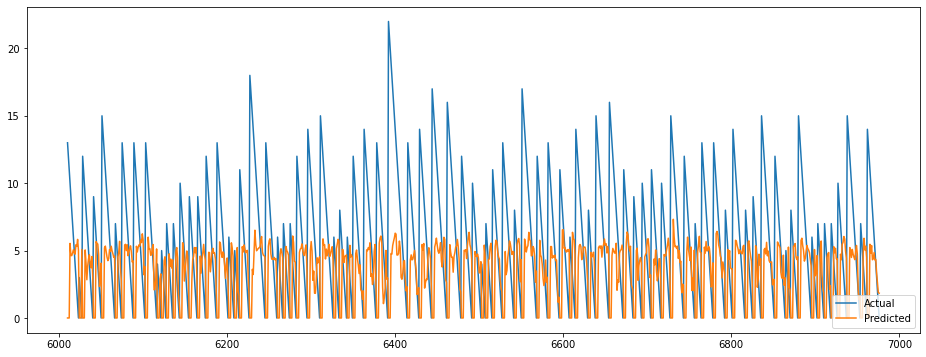

In [60]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal3)
plt.plot(timeLabels, predictedVal3)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

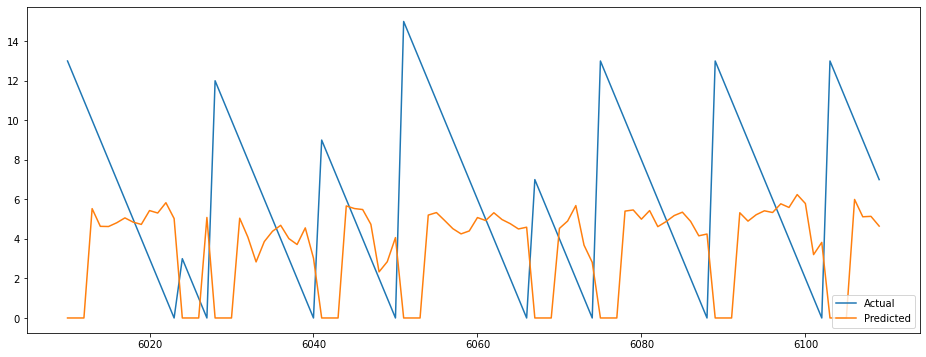

In [61]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal3[0:100])
plt.plot(timeLabels[0:100], predictedVal3[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 4: Timestep = 4, train with degradation data

For timestep = 4, results in the notebook Investigation of Training With Degradation Data model 1 is used,

In [45]:
(trainX_4step, trainY_4step, trainTime_4step) = splitDataIntoChunks3D(train_data_cleaned, 4)
(valX_4step, valY_4step, valTime_4step) = splitDataIntoChunks3D(val_data, 4)
(testX_4step, testY_4step, testTime_4step) = splitDataIntoChunks3D(test_data, 4)

In [46]:
#check shape of X (training)
trainX_4step_arr = np.array(trainX_4step)
trainX_4step_arr.shape

(3654, 4, 4)

In [47]:
#check shape of y (training)
trainY_4step_arr = np.array(trainY_4step)
trainY_4step_arr = trainY_4step_arr.reshape(-1, 1)
trainY_4step_arr.shape

(3654, 1)

In [48]:
#check shape of X (validation)
valX_4step_arr = np.array(valX_4step)
valX_4step_arr.shape

(635, 4, 4)

In [49]:
#check shape of y (validation)
valY_4step_arr = np.array(valY_4step)
valY_4step_arr = valY_4step_arr.reshape(-1, 1)
valY_4step_arr.shape

(635, 1)

In [67]:
#configure architecture 
model4 = models.Sequential()
model4.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 4), padding="same"))
model4.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model4.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model4.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Flatten())
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(1, activation='relu'))

In [68]:
model4.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [69]:
fileName4 = "CNN_timestepTest_fourTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName4,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [70]:
learning_model4 = model4.fit(trainX_4step_arr, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
115/115 [==============================] - 1s 4ms/step - loss: 20.5960 - mean_squared_error: 20.5960 - val_loss: 11.4636 - val_mean_squared_error: 11.4636
Epoch 2/500
115/115 [==============================] - 0s 3ms/step - loss: 18.9575 - mean_squared_error: 18.9575 - val_loss: 11.2978 - val_mean_squared_error: 11.2978
Epoch 3/500
115/115 [==============================] - 0s 3ms/step - loss: 18.5466 - mean_squared_error: 18.5466 - val_loss: 11.4479 - val_mean_squared_error: 11.4479
Epoch 4/500
115/115 [==============================] - 0s 3ms/step - loss: 18.3949 - mean_squared_error: 18.3949 - val_loss: 11.6108 - val_mean_squared_error: 11.6108
Epoch 5/500
115/115 [==============================] - 0s 3ms/step - loss: 17.9541 - mean_squared_error: 17.9541 - val_loss: 11.3228 - val_mean_squared_error: 11.3228
Epoch 6/500
115/115 [==============================] - 0s 4ms/step - loss: 17.8050 - mean_squared_error: 17.8050 - val_loss: 10.9906 - val_mean_squared_error: 10.990

Epoch 50/500
115/115 [==============================] - 0s 3ms/step - loss: 15.9943 - mean_squared_error: 15.9943 - val_loss: 9.9466 - val_mean_squared_error: 9.9466
Epoch 51/500
115/115 [==============================] - 0s 3ms/step - loss: 16.0971 - mean_squared_error: 16.0971 - val_loss: 10.0075 - val_mean_squared_error: 10.0075
Epoch 52/500
115/115 [==============================] - 0s 3ms/step - loss: 16.0943 - mean_squared_error: 16.0943 - val_loss: 9.9352 - val_mean_squared_error: 9.9352
Epoch 53/500
115/115 [==============================] - 0s 3ms/step - loss: 16.1537 - mean_squared_error: 16.1537 - val_loss: 9.8583 - val_mean_squared_error: 9.8583
Epoch 54/500
115/115 [==============================] - 0s 3ms/step - loss: 16.0754 - mean_squared_error: 16.0754 - val_loss: 9.8520 - val_mean_squared_error: 9.8520
Epoch 55/500
115/115 [==============================] - 0s 3ms/step - loss: 16.0637 - mean_squared_error: 16.0637 - val_loss: 10.0581 - val_mean_squared_error: 10.0581


115/115 [==============================] - 0s 4ms/step - loss: 15.3292 - mean_squared_error: 15.3292 - val_loss: 9.6327 - val_mean_squared_error: 9.6327
Epoch 149/500
115/115 [==============================] - 0s 4ms/step - loss: 15.3963 - mean_squared_error: 15.3963 - val_loss: 9.6487 - val_mean_squared_error: 9.6487
Epoch 150/500
115/115 [==============================] - 0s 3ms/step - loss: 15.3640 - mean_squared_error: 15.3640 - val_loss: 9.5161 - val_mean_squared_error: 9.5161
Epoch 151/500
115/115 [==============================] - 0s 3ms/step - loss: 15.2362 - mean_squared_error: 15.2362 - val_loss: 9.5848 - val_mean_squared_error: 9.5848
Epoch 152/500
115/115 [==============================] - 0s 4ms/step - loss: 15.4170 - mean_squared_error: 15.4170 - val_loss: 9.5562 - val_mean_squared_error: 9.5562
Epoch 153/500
115/115 [==============================] - 0s 4ms/step - loss: 15.2580 - mean_squared_error: 15.2580 - val_loss: 9.6120 - val_mean_squared_error: 9.6120
Epoch 154/50

Epoch 246/500
115/115 [==============================] - 0s 4ms/step - loss: 14.7973 - mean_squared_error: 14.7973 - val_loss: 9.6131 - val_mean_squared_error: 9.6131
Epoch 247/500
115/115 [==============================] - 0s 3ms/step - loss: 14.6957 - mean_squared_error: 14.6957 - val_loss: 9.8672 - val_mean_squared_error: 9.8672
Epoch 248/500
115/115 [==============================] - 0s 4ms/step - loss: 14.7227 - mean_squared_error: 14.7227 - val_loss: 9.4363 - val_mean_squared_error: 9.4363
Epoch 249/500
115/115 [==============================] - 0s 4ms/step - loss: 14.7135 - mean_squared_error: 14.7135 - val_loss: 9.8778 - val_mean_squared_error: 9.8778
Epoch 250/500
115/115 [==============================] - 0s 4ms/step - loss: 14.6619 - mean_squared_error: 14.6619 - val_loss: 9.7405 - val_mean_squared_error: 9.7405
Epoch 251/500
115/115 [==============================] - 0s 3ms/step - loss: 14.7725 - mean_squared_error: 14.7725 - val_loss: 9.6104 - val_mean_squared_error: 9.610

Epoch 295/500
115/115 [==============================] - 0s 3ms/step - loss: 14.3557 - mean_squared_error: 14.3557 - val_loss: 10.1186 - val_mean_squared_error: 10.1186
Epoch 296/500
115/115 [==============================] - 0s 3ms/step - loss: 14.2861 - mean_squared_error: 14.2861 - val_loss: 9.8041 - val_mean_squared_error: 9.8041
Epoch 297/500
115/115 [==============================] - 0s 3ms/step - loss: 14.2482 - mean_squared_error: 14.2482 - val_loss: 9.8875 - val_mean_squared_error: 9.8875
Epoch 298/500
115/115 [==============================] - 0s 3ms/step - loss: 14.6036 - mean_squared_error: 14.6036 - val_loss: 9.9725 - val_mean_squared_error: 9.9725
Epoch 299/500
115/115 [==============================] - 0s 4ms/step - loss: 14.3369 - mean_squared_error: 14.3369 - val_loss: 10.2499 - val_mean_squared_error: 10.2499
Epoch 300/500
115/115 [==============================] - 0s 3ms/step - loss: 14.3738 - mean_squared_error: 14.3738 - val_loss: 9.7671 - val_mean_squared_error: 9

115/115 [==============================] - 0s 3ms/step - loss: 13.8020 - mean_squared_error: 13.8020 - val_loss: 10.3526 - val_mean_squared_error: 10.3526
Epoch 392/500
115/115 [==============================] - 0s 3ms/step - loss: 13.7928 - mean_squared_error: 13.7928 - val_loss: 10.7095 - val_mean_squared_error: 10.7095
Epoch 393/500
115/115 [==============================] - 0s 3ms/step - loss: 13.8077 - mean_squared_error: 13.8077 - val_loss: 10.7972 - val_mean_squared_error: 10.7972
Epoch 394/500
115/115 [==============================] - 0s 3ms/step - loss: 13.7875 - mean_squared_error: 13.7875 - val_loss: 10.5243 - val_mean_squared_error: 10.5243
Epoch 395/500
115/115 [==============================] - 0s 3ms/step - loss: 13.9253 - mean_squared_error: 13.9253 - val_loss: 10.2087 - val_mean_squared_error: 10.2087
Epoch 396/500
115/115 [==============================] - 0s 3ms/step - loss: 13.9592 - mean_squared_error: 13.9592 - val_loss: 10.6453 - val_mean_squared_error: 10.6453


115/115 [==============================] - 0s 3ms/step - loss: 13.0662 - mean_squared_error: 13.0662 - val_loss: 11.0456 - val_mean_squared_error: 11.0456
Epoch 488/500
115/115 [==============================] - 0s 3ms/step - loss: 12.9563 - mean_squared_error: 12.9563 - val_loss: 11.1721 - val_mean_squared_error: 11.1721
Epoch 489/500
115/115 [==============================] - 0s 3ms/step - loss: 13.0676 - mean_squared_error: 13.0676 - val_loss: 10.7826 - val_mean_squared_error: 10.7826
Epoch 490/500
115/115 [==============================] - 0s 3ms/step - loss: 12.9588 - mean_squared_error: 12.9588 - val_loss: 10.9663 - val_mean_squared_error: 10.9663
Epoch 491/500
115/115 [==============================] - 0s 3ms/step - loss: 12.9908 - mean_squared_error: 12.9908 - val_loss: 11.0217 - val_mean_squared_error: 11.0217
Epoch 492/500
115/115 [==============================] - 0s 3ms/step - loss: 14.0087 - mean_squared_error: 14.0087 - val_loss: 10.5706 - val_mean_squared_error: 10.5706


In [50]:
model4 = tf.keras.models.load_model('CNN_timestepTest_fourTimestep.h5')

Results from model 1 of Investigation of Training With Degradation Data.ipynb are used for this experiment. 

In [51]:
#performance on training set
trainPredict4 = model4.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore4 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict4))
trainR2Score4 = r2_score(trainY_4step_arr, trainPredict4)
trainSscore4 = findSscore(trainY_4step_arr, trainPredict4)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore4, trainR2Score4, trainSscore4))

Train Score: 4.0123 RMSE 0.1129 R2 Score 4826.0565 S score


In [53]:
#performance on validation set
valPredict4 = model4.predict(valX_4step_arr)
# calculate root mean squared error
valScore4 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict4))
valR2Score4 = r2_score(valY_4step_arr, valPredict4)
valSscore4 = findSscore(valY_4step_arr, valPredict4)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore4, valR2Score4, valSscore4))

Validation Score: 3.0624 RMSE 0.1813 R2 Score 800.2094 S score


In [74]:
(actualVal4, predictedVal4) = getRULValues(valPredict4, allRUL, valTime_4step, 6010, 6976)

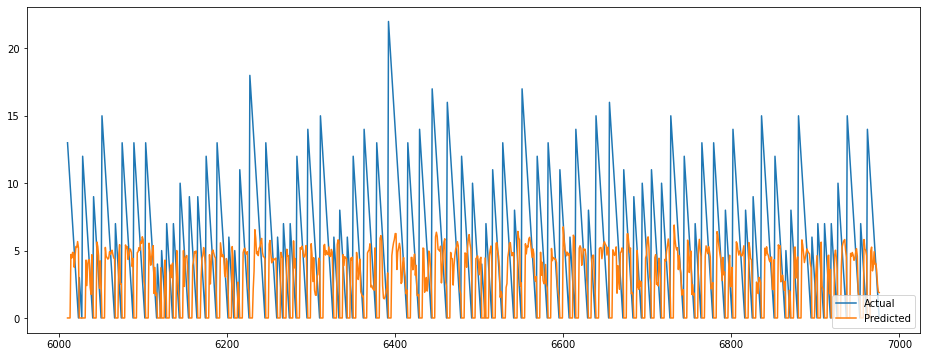

In [75]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal4)
plt.plot(timeLabels, predictedVal4)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

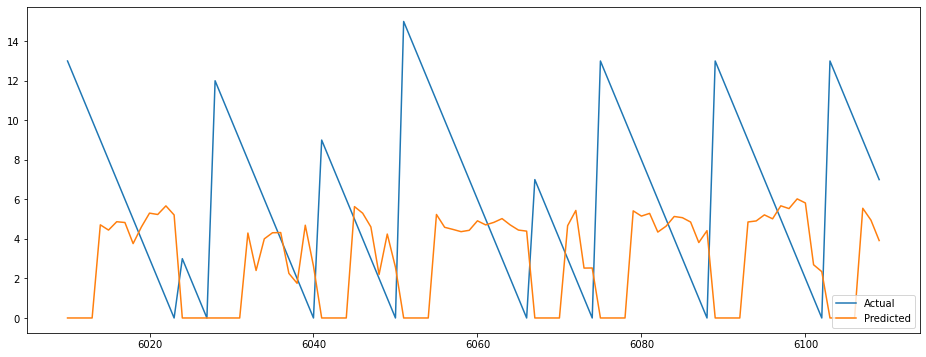

In [76]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal4[0:100])
plt.plot(timeLabels[0:100], predictedVal4[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 5: Timestep = 5, train with degradation data

In [54]:
(trainX_5step, trainY_5step, trainTime_5step) = splitDataIntoChunks3D(train_data_cleaned, 5)
(valX_5step, valY_5step, valTime_5step) = splitDataIntoChunks3D(val_data, 5)
(testX_5step, testY_5step, testTime_5step) = splitDataIntoChunks3D(test_data, 5)

In [55]:
#check shape of X (training)
trainX_5step_arr = np.array(trainX_5step)
trainX_5step_arr.shape

(3227, 5, 4)

In [56]:
#check shape of y (training)
trainY_5step_arr = np.array(trainY_5step)
trainY_5step_arr = trainY_5step_arr.reshape(-1, 1)
trainY_5step_arr.shape

(3227, 1)

In [57]:
#check shape of X (validation)
valX_5step_arr = np.array(valX_5step)
valX_5step_arr.shape

(553, 5, 4)

In [58]:
#check shape of y (validation)
valY_5step_arr = np.array(valY_5step)
valY_5step_arr = valY_5step_arr.reshape(-1, 1)
valY_5step_arr.shape

(553, 1)

In [82]:
#configure architecture 
model5 = models.Sequential()
model5.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(5, 4), padding="same"))
model5.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model5.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model5.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Flatten())
model5.add(layers.Dense(100, activation='relu'))
model5.add(layers.Dense(1, activation='relu'))

In [83]:
model5.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [84]:
fileName5 = "CNN_timestepTest_fiveTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName5,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [85]:
learning_model5 = model5.fit(trainX_5step_arr, trainY_5step_arr, epochs=500, batch_size=32, validation_data=(valX_5step_arr, valY_5step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
101/101 [==============================] - 1s 4ms/step - loss: 19.0107 - mean_squared_error: 19.0107 - val_loss: 10.2975 - val_mean_squared_error: 10.2975
Epoch 2/500
101/101 [==============================] - 0s 3ms/step - loss: 17.5171 - mean_squared_error: 17.5171 - val_loss: 9.9408 - val_mean_squared_error: 9.9408
Epoch 3/500
101/101 [==============================] - 0s 3ms/step - loss: 16.9836 - mean_squared_error: 16.9836 - val_loss: 9.8584 - val_mean_squared_error: 9.8584
Epoch 4/500
101/101 [==============================] - 0s 3ms/step - loss: 17.2202 - mean_squared_error: 17.2202 - val_loss: 9.7302 - val_mean_squared_error: 9.7302
Epoch 5/500
101/101 [==============================] - 0s 4ms/step - loss: 16.9303 - mean_squared_error: 16.9303 - val_loss: 9.6077 - val_mean_squared_error: 9.6077
Epoch 6/500
101/101 [==============================] - 0s 4ms/step - loss: 16.6159 - mean_squared_error: 16.6159 - val_loss: 9.4477 - val_mean_squared_error: 9.4477
Epoch 7/

101/101 [==============================] - 0s 3ms/step - loss: 14.6203 - mean_squared_error: 14.6203 - val_loss: 8.4262 - val_mean_squared_error: 8.4262
Epoch 100/500
101/101 [==============================] - 0s 3ms/step - loss: 14.5463 - mean_squared_error: 14.5463 - val_loss: 8.4709 - val_mean_squared_error: 8.4709
Epoch 101/500
101/101 [==============================] - 0s 3ms/step - loss: 14.5191 - mean_squared_error: 14.5191 - val_loss: 8.4241 - val_mean_squared_error: 8.4241
Epoch 102/500
101/101 [==============================] - 0s 3ms/step - loss: 14.4822 - mean_squared_error: 14.4822 - val_loss: 8.5035 - val_mean_squared_error: 8.5035
Epoch 103/500
101/101 [==============================] - 0s 3ms/step - loss: 14.3822 - mean_squared_error: 14.3822 - val_loss: 8.2274 - val_mean_squared_error: 8.2274
Epoch 104/500
101/101 [==============================] - 0s 3ms/step - loss: 14.5130 - mean_squared_error: 14.5130 - val_loss: 8.4134 - val_mean_squared_error: 8.4134
Epoch 105/50

101/101 [==============================] - 0s 4ms/step - loss: 13.8668 - mean_squared_error: 13.8668 - val_loss: 8.7948 - val_mean_squared_error: 8.7948
Epoch 198/500
101/101 [==============================] - 0s 3ms/step - loss: 13.8750 - mean_squared_error: 13.8750 - val_loss: 8.8627 - val_mean_squared_error: 8.8627
Epoch 199/500
101/101 [==============================] - 0s 4ms/step - loss: 13.7547 - mean_squared_error: 13.7547 - val_loss: 8.8085 - val_mean_squared_error: 8.8085
Epoch 200/500
101/101 [==============================] - 0s 4ms/step - loss: 13.7857 - mean_squared_error: 13.7857 - val_loss: 8.5984 - val_mean_squared_error: 8.5984
Epoch 201/500
101/101 [==============================] - 0s 4ms/step - loss: 13.7670 - mean_squared_error: 13.7670 - val_loss: 8.6776 - val_mean_squared_error: 8.6776
Epoch 202/500
101/101 [==============================] - 0s 3ms/step - loss: 13.8342 - mean_squared_error: 13.8342 - val_loss: 8.8345 - val_mean_squared_error: 8.8345
Epoch 203/50

Epoch 295/500
101/101 [==============================] - 0s 4ms/step - loss: 12.8234 - mean_squared_error: 12.8234 - val_loss: 8.5972 - val_mean_squared_error: 8.5972
Epoch 296/500
101/101 [==============================] - 0s 4ms/step - loss: 12.9922 - mean_squared_error: 12.9922 - val_loss: 9.0530 - val_mean_squared_error: 9.0530
Epoch 297/500
101/101 [==============================] - 0s 4ms/step - loss: 13.1374 - mean_squared_error: 13.1374 - val_loss: 9.1024 - val_mean_squared_error: 9.1024
Epoch 298/500
101/101 [==============================] - 0s 4ms/step - loss: 12.9515 - mean_squared_error: 12.9515 - val_loss: 8.8616 - val_mean_squared_error: 8.8616
Epoch 299/500
101/101 [==============================] - 0s 4ms/step - loss: 12.9402 - mean_squared_error: 12.9402 - val_loss: 9.0857 - val_mean_squared_error: 9.0857
Epoch 300/500
101/101 [==============================] - 0s 4ms/step - loss: 12.9440 - mean_squared_error: 12.9440 - val_loss: 9.1404 - val_mean_squared_error: 9.140

101/101 [==============================] - 0s 4ms/step - loss: 12.2719 - mean_squared_error: 12.2719 - val_loss: 9.2797 - val_mean_squared_error: 9.2797
Epoch 345/500
101/101 [==============================] - 0s 4ms/step - loss: 12.2029 - mean_squared_error: 12.2029 - val_loss: 9.2719 - val_mean_squared_error: 9.2719
Epoch 346/500
101/101 [==============================] - 0s 3ms/step - loss: 12.5650 - mean_squared_error: 12.5650 - val_loss: 9.1289 - val_mean_squared_error: 9.1289
Epoch 347/500
101/101 [==============================] - 0s 3ms/step - loss: 12.4327 - mean_squared_error: 12.4327 - val_loss: 9.2045 - val_mean_squared_error: 9.2045
Epoch 348/500
101/101 [==============================] - 0s 3ms/step - loss: 12.3630 - mean_squared_error: 12.3630 - val_loss: 9.1578 - val_mean_squared_error: 9.1578
Epoch 349/500
101/101 [==============================] - 0s 3ms/step - loss: 12.0934 - mean_squared_error: 12.0934 - val_loss: 9.4609 - val_mean_squared_error: 9.4609
Epoch 350/50

101/101 [==============================] - 0s 4ms/step - loss: 11.4436 - mean_squared_error: 11.4436 - val_loss: 9.6472 - val_mean_squared_error: 9.6472
Epoch 443/500
101/101 [==============================] - 0s 3ms/step - loss: 11.4902 - mean_squared_error: 11.4902 - val_loss: 9.5627 - val_mean_squared_error: 9.5627
Epoch 444/500
101/101 [==============================] - 0s 3ms/step - loss: 11.6197 - mean_squared_error: 11.6197 - val_loss: 10.0236 - val_mean_squared_error: 10.0236
Epoch 445/500
101/101 [==============================] - 0s 3ms/step - loss: 11.4607 - mean_squared_error: 11.4607 - val_loss: 9.7789 - val_mean_squared_error: 9.7789
Epoch 446/500
101/101 [==============================] - 0s 3ms/step - loss: 11.3190 - mean_squared_error: 11.3190 - val_loss: 9.7709 - val_mean_squared_error: 9.7709
Epoch 447/500
101/101 [==============================] - 0s 3ms/step - loss: 11.2263 - mean_squared_error: 11.2263 - val_loss: 9.7773 - val_mean_squared_error: 9.7773
Epoch 448/

Epoch 491/500
101/101 [==============================] - 0s 4ms/step - loss: 10.9974 - mean_squared_error: 10.9974 - val_loss: 10.1178 - val_mean_squared_error: 10.1178
Epoch 492/500
101/101 [==============================] - 0s 3ms/step - loss: 10.8313 - mean_squared_error: 10.8313 - val_loss: 10.0517 - val_mean_squared_error: 10.0517
Epoch 493/500
101/101 [==============================] - 0s 4ms/step - loss: 11.2375 - mean_squared_error: 11.2375 - val_loss: 10.0556 - val_mean_squared_error: 10.0556
Epoch 494/500
101/101 [==============================] - 0s 4ms/step - loss: 11.2239 - mean_squared_error: 11.2239 - val_loss: 10.6064 - val_mean_squared_error: 10.6064
Epoch 495/500
101/101 [==============================] - 0s 4ms/step - loss: 11.1501 - mean_squared_error: 11.1501 - val_loss: 9.6861 - val_mean_squared_error: 9.6861
Epoch 496/500
101/101 [==============================] - 0s 4ms/step - loss: 10.8775 - mean_squared_error: 10.8775 - val_loss: 10.5606 - val_mean_squared_err

In [59]:
model5 = tf.keras.models.load_model('CNN_timestepTest_fiveTimestep.h5')

In [60]:
#performance on training set
trainPredict5 = model5.predict(trainX_5step_arr)
# calculate root mean squared error
trainScore5 = math.sqrt(mean_squared_error(trainY_5step_arr, trainPredict5))
trainR2Score5 = r2_score(trainY_5step_arr, trainPredict5)
trainSscore5 = findSscore(trainY_5step_arr, trainPredict5)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore5, trainR2Score5, trainSscore5))

Train Score: 3.8207 RMSE 0.1315 R2 Score 4228.6160 S score


In [61]:
#performance on validation set
valPredict5 = model5.predict(valX_5step_arr)
# calculate root mean squared error
valScore5 = math.sqrt(mean_squared_error(valY_5step_arr, valPredict5))
valR2Score5 = r2_score(valY_5step_arr, valPredict5)
valSscore5 = findSscore(valY_5step_arr, valPredict5)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore5, valR2Score5, valSscore5))

Validation Score: 2.8405 RMSE 0.1990 R2 Score 690.4003 S score


In [89]:
(actualVal5, predictedVal5) = getRULValues(valPredict5, allRUL, valTime_5step, 6010, 6976)

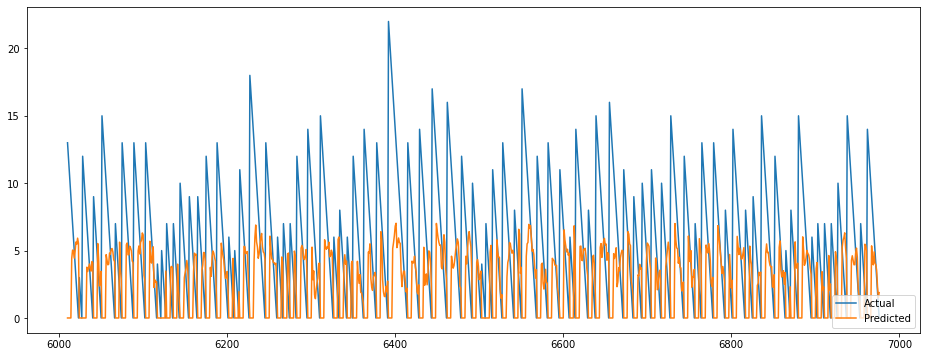

In [90]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal5)
plt.plot(timeLabels, predictedVal5)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

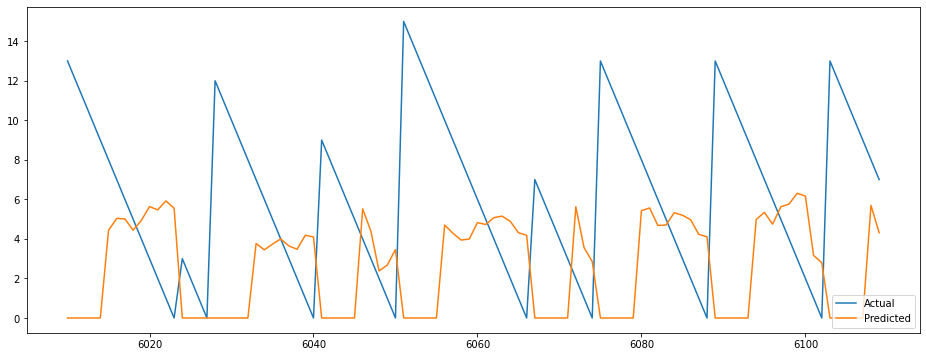

In [91]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal5[0:100])
plt.plot(timeLabels[0:100], predictedVal5[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [92]:
timeLabels[30]

6040

In [93]:
predictedVal5[22:32]

[0,
 array([3.7691817], dtype=float32),
 array([3.4464025], dtype=float32),
 array([3.7374015], dtype=float32),
 array([4.000186], dtype=float32),
 array([3.6453629], dtype=float32),
 array([3.4751158], dtype=float32),
 array([4.183734], dtype=float32),
 array([4.0996656], dtype=float32),
 0]